In [1]:
import numpy as np
from quimb.utils import progbar as Progbar
from mpi4py import MPI
import pickle
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# torch
from torch.nn.parameter import Parameter
import torch
import torch.nn as nn
torch.autograd.set_detect_anomaly(False)

# quimb
import quimb as qu
import quimb.tensor as qtn
import autoray as ar
from autoray import do

from vmc_torch.experiment.tn_model import fTNModel, fTN_NN_proj_variable_Model
from vmc_torch.experiment.tn_model import fTN_Transformer_Model, fTN_Transformer_Proj_lazy_Model
from vmc_torch.experiment.tn_model import init_weights_xavier, init_weights_kaiming, init_weights_to_zero
from vmc_torch.sampler import MetropolisExchangeSamplerSpinless, MetropolisExchangeSamplerSpinful
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import TrivialPreconditioner, SignedSGD, SGD, SR
from vmc_torch.VMC import VMC
from vmc_torch.hamiltonian import spinful_Fermi_Hubbard_square_lattice, spinless_Fermi_Hubbard_square_lattice
from vmc_torch.torch_utils import SVD,QR

# Register safe SVD and QR functions to torch
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)

from vmc_torch.global_var import DEBUG


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
Lx = int(4)
Ly = int(4)
symmetry = 'U1'
t = 1.0
U = 8.0
N_f = int(Lx*Ly)
n_fermions_per_spin = (N_f//2, N_f//2)
H = spinful_Fermi_Hubbard_square_lattice(Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
graph = H.graph
# TN parameters
D = 4
chi = 8
dtype=torch.float64

# Load PEPS
skeleton = pickle.load(open(f"../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl", "rb"))
peps_params = pickle.load(open(f"../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl", "rb"))
peps = qtn.unpack(peps_params, skeleton)
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype))

# VMC sample size
N_samples = 2000
N_samples = N_samples - N_samples % SIZE + SIZE
if (N_samples/SIZE)%2 != 0:
    N_samples += SIZE

# model = fTNModel(peps, max_bond=chi)
# model = fTN_NNiso_Model(peps, max_bond=chi, nn_hidden_dim=8, nn_eta=1e-3)
# model = fTN_NN_Model(peps, max_bond=chi, nn_hidden_dim=8, nn_eta=1e-3)
# model = fTN_Transformer_Model(
#     peps, 
#     max_bond=chi, 
#     nn_eta=1.0, 
#     d_model=8, 
#     nhead=2, 
#     num_encoder_layers=2, 
#     num_decoder_layers=2,
#     dim_feedforward=32,
#     dropout=0.0,
# )
model = fTN_Transformer_Proj_lazy_Model(
    peps,
    max_bond=chi,
    nn_eta=1.0,
    d_model=2**2,
    nhead=2,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=2**5,
    dropout=0.0,
    dtype=dtype,
)

import jax
dummy_config = H.hilbert.random_state(key=jax.random.PRNGKey(0))
model = fTN_NN_proj_variable_Model(peps, max_bond=chi, nn_eta=1.0, nn_hidden_dim=32, dtype=dtype, padded_length=30, dummy_config=dummy_config, lazy=True)
model.apply(lambda x: init_weights_to_zero(x, std=2e-2))

# model.apply(init_weights_to_zero)
# model.apply(init_weights_xavier)

model_names = {
    fTNModel: 'fTN',
    fTN_Transformer_Model: 'fTN_Transformer',
    fTN_Transformer_Proj_lazy_Model: 'fTN_Transformer_Proj_lazy',
    fTN_NN_proj_variable_Model: 'fTN_NN_proj_variable',
    
}
model_name = model_names.get(type(model), 'UnknownModel')

init_step = 0
total_steps = 200
if init_step != 0:
    saved_model_params = torch.load(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/{model_name}/chi={chi}/model_params_step{init_step}.pth')
    saved_model_state_dict = saved_model_params['model_state_dict']
    saved_model_params_vec = torch.tensor(saved_model_params['model_params_vec'])
    try:
        model.load_state_dict(saved_model_state_dict)
    except:
        model.load_params(saved_model_params_vec)

# optimizer = SignedSGD(learning_rate=0.05)
optimizer = SGD(learning_rate=0.05)
sampler = MetropolisExchangeSamplerSpinful(H.hilbert, graph, N_samples=N_samples, burn_in_steps=16, reset_chain=False, random_edge=True, dtype=dtype)
# sampler = None
variational_state = Variational_State(model, hi=H.hilbert, sampler=sampler, dtype=dtype)
preconditioner = SR(dense=False, exact=True if sampler is None else False, use_MPI4Solver=True, diag_eta=0.05, iter_step=1e5, dtype=dtype)
# preconditioner = TrivialPreconditioner()
vmc = VMC(H, variational_state, optimizer, preconditioner)

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from vmc_torch.fermion_utils import insert_proj_peps
for _ in range(200):
    random_seed = np.random.randint(0, 2**32)
    dummy_config = H.hilbert.random_state(key=jax.random.PRNGKey(random_seed))
    amp = peps.get_amp(dummy_config)
    amp_w_proj = insert_proj_peps(amp, max_bond=6, yrange=[0, peps.Ly-2], lazy=True)
# amp_w_proj.draw(color='proj')
# amp.contract(), amp_w_proj.contract()

In [2]:
model.num_params, model.num_tn_params

(13808, 1648)

In [9]:
model

fTN_Transformer_Proj_lazy_Model(
  (torch_tn_params): ModuleDict(
    (0): ParameterDict(
        ((-1, -1, 2)): Parameter containing: [torch.DoubleTensor of size 1x2x1]
        ((-1, 0, 1)): Parameter containing: [torch.DoubleTensor of size 1x1x2]
        ((0, -1, 1)): Parameter containing: [torch.DoubleTensor of size 2x2x2]
        ((0, -2, 2)): Parameter containing: [torch.DoubleTensor of size 2x1x1]
        ((0, 0, 0)): Parameter containing: [torch.DoubleTensor of size 2x1x1]
        ((1, -1, 0)): Parameter containing: [torch.DoubleTensor of size 1x2x1]
        ((1, -2, 1)): Parameter containing: [torch.DoubleTensor of size 1x1x2]
    )
    (1): ParameterDict(
        ((-1, -1, -1, 2)): Parameter containing: [torch.DoubleTensor of size 1x1x1x1]
        ((-1, -1, 0, 1)): Parameter containing: [torch.DoubleTensor of size 1x1x2x2]
        ((-1, -1, 1, 0)): Parameter containing: [torch.DoubleTensor of size 1x1x1x1]
        ((-1, 0, -1, 1)): Parameter containing: [torch.DoubleTensor of 

In [363]:
import jax
import pyinstrument
from vmc_torch.fermion_utils import insert_proj_peps
random_config = H.hilbert.random_state(key=jax.random.PRNGKey(1))
random_config = torch.tensor(random_config, dtype=dtype)
amp = peps.get_amp(random_config)
model(random_config), amp.contract()

(tensor([-2.5298e-12], dtype=torch.float64, grad_fn=<StackBackward0>),
 tensor(-2.5298e-12, dtype=torch.float64))

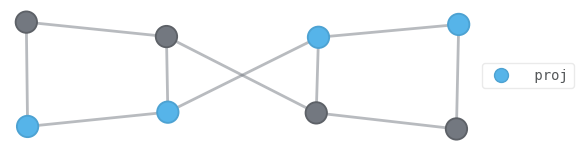

In [364]:
insert_proj_peps(amp, max_bond=4, yrange=[0,peps.Ly-2], lazy=False).draw(color='proj')

In [365]:
with pyinstrument.Profiler() as prof:
    model(random_config)
prof.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 19:08:56  Samples:  86
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.089     CPU time: 0.089
/   _/                      v4.7.3

Profile at /tmp/ipykernel_23605/1791513093.py:1

0.087 <module>  ../../../../../tmp/ipykernel_23605/1791513093.py:1
└─ 0.087 fTNModel._wrapped_call_impl  torch/nn/modules/module.py:1549
      [0 frames hidden]  
         0.087 fTNModel._call_impl  torch/nn/modules/module.py:1555
         └─ 0.087 fTNModel.forward  tn_model.py:146
            └─ 0.087 fTNModel.amplitude  tn_model.py:118
               ├─ 0.055 PEPS.contract_boundary_from_ymin  quimb/tensor/tensor_2d.py:2007
               │  └─ 0.055 PEPS.contract_boundary_from  quimb/tensor/tensor_2d.py:1715
               │     └─ 0.055 PEPS._contract_boundary_core  quimb/tensor/tensor_2d.py:1316
               │        ├─ 0.028 PEPS.canonize_plane  quimb/tensor/tensor_2d.py:914
               │        │  └─ 0.028 PEPS.canonize_between  quimb/tensor/tensor_c

In [366]:
# Transformer model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


class TransformerModel(nn.Module):
    def __init__(
            self, 
            output_size=1,
            phys_dim=2,
            d_model=128, 
            nhead=8, 
            num_encoder_layers=6, 
            num_decoder_layers=6, 
            dim_feedforward=512, 
            dropout=0.1
        ):
        super(TransformerModel, self).__init__()
        # Embedding layer for integer input sequence
        self.embedding = nn.Embedding(phys_dim, d_model)
        # Embedding layer for floating-point input sequence
        self.float_embedding = nn.Linear(1, d_model)
        # Positional encoding for fixed-length sequences
        self.pos_encoder = PositionalEncoding(d_model)
        # Transformer layers
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
        # Linear layer for output generation
        self.fc_out = nn.Linear(d_model, output_size)
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src = src.transpose(0, 1) # [seq_len, batch_size]
        tgt = tgt.transpose(0, 1)
        # Encode source (input) sequence
        src = self.embedding(src) * torch.sqrt(torch.tensor(self.embedding.embedding_dim, dtype=torch.float32))
        src = self.pos_encoder(src)
        # Encode target (output) sequence
        tgt = self.float_embedding(tgt) * torch.sqrt(torch.tensor(self.float_embedding.out_features, dtype=torch.float32))
        tgt = self.pos_encoder(tgt)
        # Apply transformer
        output = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask)
        # Generate output for each position in the sequence
        output = self.fc_out(output)
        # Transpose output to match the shape [batch_size, seq_len, output_size]
        output = output.transpose(0, 1)
        return output

In [367]:
random_config = torch.tensor(H.hilbert.random_state(key=jax.random.PRNGKey(1)))
transformer_model = TransformerModel(phys_dim=4, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=2**7, d_model=2**7, nhead=8)

In [368]:
peps.phys_dim()

4

In [369]:
# amp = peps.get_amp(random_config)
# amp_w_proj = insert_proj_peps(amp, max_bond=4, yrange=[0,peps.Ly-2], lazy=True)

# tn, proj_tn = amp_w_proj.partition('proj')
input = random_config.unsqueeze(0)
target = torch.randn(1, 32, 1)
output = transformer_model(input, target)
output.shape, input.shape, target.shape, output.view(-1)

(torch.Size([1, 32, 1]),
 torch.Size([1, 16]),
 torch.Size([1, 32, 1]),
 tensor([ 0.1063,  0.2415,  0.0898, -0.0838,  0.3662,  0.1214,  0.1259,  0.1299,
          0.3637,  0.4221,  0.3693,  0.2376,  0.5999,  0.4905, -0.2253,  0.0418,
          0.2510, -0.2236,  0.2471,  0.2663,  0.1220,  0.3799,  0.0450,  0.6811,
          0.3537,  0.8089,  0.4712,  0.1701,  0.3547,  0.5257,  0.4483,  0.1982],
        grad_fn=<ViewBackward0>))

In [370]:
from vmc_torch.fermion_utils import flatten_proj_params, reconstruct_proj_params, insert_compressor
import ast
from quimb.tensor.tensor_core import bonds, tags_to_oset, rand_uuid
from quimb.tensor.tensor_2d import Rotator2D, pairwise
class fTN_Transformer_Proj_lazy_Model(torch.nn.Module):
    def __init__(
            self, 
            ftn, 
            max_bond, 
            nn_eta=1e-3, 
            d_model=128, 
            nhead=8, 
            num_encoder_layers=6, 
            num_decoder_layers=6, 
            dim_feedforward=512, 
            dropout=0.1,
            param_dtype=torch.float32,
            lazy=False,
        ):
        super().__init__()
        self.max_bond = max_bond
        self.nn_eta = nn_eta
        self.phys_dim = ftn.phys_dim()
        self.param_dtype = param_dtype
        self.lazy = lazy
        # extract the raw arrays and a skeleton of the TN
        params, self.skeleton = qtn.pack(ftn)

        # Flatten the dictionary structure and assign each parameter as a part of a ModuleDict
        self.torch_tn_params = nn.ModuleDict({
            str(tid): nn.ParameterDict({
                str(sector): nn.Parameter(data)
                for sector, data in blk_array.items()
            })
            for tid, blk_array in params.items()
        })
        
        self.charge_config = [array.charge for array in ftn.arrays]
        self.N_fermion = sum(self.charge_config)

        # Get symmetry
        self.symmetry = ftn.arrays[0].symmetry
        assert self.symmetry == 'Z2' or self.symmetry == 'U1', "Only Z2 or U1 symmetry fPEPS is supported for Transformer insertion now."
        if self.symmetry == 'Z2':
            assert self.N_fermion %2 == sum(self.charge_config) % 2, "The number of fermions must match the parity of the Z2-TNS."
        
        # Transformer model
        self.d_model = d_model # embedding dimension
        self.transformer = TransformerModel(
            output_size=1,
            phys_dim=self.phys_dim,
            d_model=self.d_model, 
            nhead=nhead, 
            num_encoder_layers=num_encoder_layers, 
            num_decoder_layers=num_decoder_layers, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout
        )

        # Store the shapes of the parameters
        self.param_shapes = [param.shape for param in self.parameters()]

        self.model_structure = {
            'fPEPS (transformer-two-row)':{'D': ftn.max_bond(), 'chi': self.max_bond, 'Lx': ftn.Lx, 'Ly': ftn.Ly, 'symmetry': self.symmetry},
            'transformer':{'input_size': ftn.nsites, 'output_size': 1}
        }

    def from_params_to_vec(self):
        return torch.cat([param.data.flatten() for param in self.parameters()])
    
    @property
    def num_params(self):
        return len(self.from_params_to_vec())
    
    @property
    def num_tn_params(self):
        num=0
        for tid, blk_array in self.torch_tn_params.items():
            for sector, data in blk_array.items():
                num += data.numel()
        return num
    
    def params_grad_to_vec(self):
        param_grad_vec = torch.cat([param.grad.flatten() if param.grad is not None else torch.zeros_like(param).flatten() for param in self.parameters()])
        return param_grad_vec

    def clear_grad(self):
        for param in self.parameters():
            param.grad = None
    
    def load_params(self, new_params):
        pointer = 0
        for param, shape in zip(self.parameters(), self.param_shapes):
            num_param = param.numel()
            new_param_values = new_params[pointer:pointer+num_param].view(shape)
            with torch.no_grad():
                param.copy_(new_param_values)
            pointer += num_param
    
    def add_transformer_values(self, proj_tn, x_i):
        """Obtain the new amplitude with projectors TN by adding the output of the transformer to the projectors."""
        proj_params, proj_skeleton = qtn.pack(proj_tn)
        proj_params_vec = flatten_proj_params(proj_params)

        # Check x_i type
        if not type(x_i) == torch.Tensor or x_i.dtype != torch.int32:
            x_i = torch.tensor(x_i, dtype=torch.int32)

        # Input of the transformer
        src = x_i.unsqueeze(0) # Shape: [batch_size==1, seq_len]
        # Target of the transformer
        tgt = torch.tensor(proj_params_vec, dtype=self.param_dtype).unsqueeze(0) # Shape: [batch_size==1, seq_len]
        tgt.unsqueeze_(-1) # Shape: [batch_size==1, seq_len, 1]
        # Forward pass
        nn_output = self.transformer(src, tgt)
        # concatenate the output to get the final vector of length vec_len
        nn_output = nn_output.view(-1)
        # Add NN output
        proj_params_vec = proj_params_vec + self.nn_eta*nn_output
        # Reconstruct the proj parameters
        new_proj_params = reconstruct_proj_params(proj_params_vec, proj_params)
        # Load the new parameters
        new_proj_tn = qtn.unpack(new_proj_params, proj_skeleton)

        return new_proj_tn

    def amplitude(self, x):
        # Reconstruct the original parameter structure (by unpacking from the flattened dict)
        params = {
            int(tid): {
                ast.literal_eval(sector): data
                for sector, data in blk_array.items()
            }
            for tid, blk_array in self.torch_tn_params.items()
        }
        # Reconstruct the TN with the new parameters
        psi = qtn.unpack(params, self.skeleton)
        # `x` is expected to be batched as (batch_size, input_dim)
        # Loop through the batch and compute amplitude for each sample
        batch_amps = []
        for x_i in x:
            amp = psi.get_amp(x_i, conj=True)
            # Insert projectors
            """Insert projectors in a PEPS along the x direction towards y direction."""
            r = Rotator2D(amp, xrange=None, yrange=[0, psi.Ly-2], from_which='ymin')
            tn_calc = amp.copy()
            tn_body_nn_value = None
            for i, inext in pairwise(r.sweep):
                i_passed = [x for x in range(i)]
                for j in r.sweep_other:
                    # this handles cyclic boundary conditions
                    jnext = r.get_jnext(j)
                    if jnext is not None:
                        ltags = tuple([r.site_tag(ip, j) for ip in i_passed])+(r.site_tag(i, j), r.site_tag(inext, j))
                        rtags = tuple([r.site_tag(ip, jnext) for ip in i_passed])+(r.site_tag(i, jnext), r.site_tag(inext, jnext))
                        new_ltags = (r.site_tag(inext, j),)
                        new_rtags = (r.site_tag(inext, jnext),)
                        #      │         │
                        #    ──O─┐ chi ┌─O──  j+1
                        #      │ └─▷═◁─┘│
                        #      │ ┌┘   └┐ │
                        #    ──O─┘     └─O──  j
                        #     i+1        i
                        tn_calc = insert_compressor(
                            tn_calc,
                            ltags,
                            rtags,
                            new_ltags=new_ltags,
                            new_rtags=new_rtags,
                            max_bond=self.max_bond,
                        )
                
                tn_body, proj_tn = tn_calc.partition('proj') # projectors computed from untouched TN
                _, tn_body_skeleton = qtn.pack(tn_body)
                new_proj_tn = self.add_transformer_values(proj_tn, x_i) # Add transformer values to the projectors
                
                if tn_body_nn_value is None:
                    tn_body_nn = tn_body.copy()
                else:
                    tn_body_nn = reload_tn(tn_body_skeleton, tn_body_nn_value)
                
                tn_calc_nn = tn_body_nn | new_proj_tn
                
                # contract each pair of boundary tensors with their projectors
                for j in r.sweep_other:
                    tn_calc.contract_tags_(
                        (r.site_tag(i, j), r.site_tag(inext, j)),
                    )
                    tn_calc_nn.contract_tags_(
                        (r.site_tag(i, j), r.site_tag(inext, j)),
                    )
                tn_body_nn_value = tn_calc_nn.copy()

            amp_value = tn_calc_nn.contract()
            if amp_value == 0:
                amp_value = torch.tensor(0.0, dtype=self.param_dtype)
            batch_amps.append(amp_value)

        # Return the batch of amplitudes stacked as a tensor
        return torch.stack(batch_amps)
    
    def forward(self, x):
        if x.ndim == 1:
            # If input is not batched, add a batch dimension
            x = x.unsqueeze(0)
        return self.amplitude(x)
    
def reload_tn(old_tn, new_value_tn):
    """Reload the data of the tensors in old_tn with the data of the tensors with the same tags in new_value_tn."""
    for old_ts in old_tn:
        tags = old_ts.tags
        new_ts_ = new_value_tn.select_tensors(tags)
        assert len(new_ts_) == 1, 'Tensor must be unique.'
        new_ts = new_ts_[0]
        # print(old_ts.inds, new_ts.inds, old_ts.data.shape, new_ts.data.shape)
        old_ts.modify(data=new_ts.data)
    return old_tn

In [395]:
peps_model = fTN_Transformer_Proj_lazy_Model(
    peps,
    max_bond=chi,
    nn_eta=1.0,
    d_model=32,
    nhead=2,
    num_encoder_layers=1,
    num_decoder_layers=1,
    dim_feedforward=32,
    dropout=0.0,
)
peps_model(random_config), peps.get_amp(random_config).contract()

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_23605/3718476108.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_i = torch.tensor(x_i, dtype=torch.int32)
/tmp/ipykernel_23605/3718476108.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt = torch.tensor(proj_params_vec, dtype=self.param_dtype).unsquee

(tensor([2.6328e-06], dtype=torch.float64, grad_fn=<StackBackward0>),
 tensor(-2.5298e-12, dtype=torch.float64))

In [396]:
peps_model.zero_grad()
peps_model(random_config).backward()
peps_model.params_grad_to_vec()

/tmp/ipykernel_23605/3718476108.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_i = torch.tensor(x_i, dtype=torch.int32)
/tmp/ipykernel_23605/3718476108.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt = torch.tensor(proj_params_vec, dtype=self.param_dtype).unsqueeze(0) # Shape: [batch_size==1, seq_len]


tensor([-1.1678e-04,  3.6532e-04,  0.0000e+00,  ...,  2.4260e-05,
        -6.7946e-05, -2.5571e-05], dtype=torch.float64)

In [397]:
peps_model.from_params_to_vec().shape

torch.Size([19217])

In [373]:
with pyinstrument.Profiler() as prof:
    peps_model(random_config)
prof.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 19:08:59  Samples:  163
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.165     CPU time: 0.165
/   _/                      v4.7.3

Profile at /tmp/ipykernel_23605/817398746.py:1

0.165 <module>  ../../../../../tmp/ipykernel_23605/817398746.py:1
└─ 0.165 fTN_Transformer_Proj_lazy_Model._wrapped_call_impl  torch/nn/modules/module.py:1549
      [0 frames hidden]  
         0.165 fTN_Transformer_Proj_lazy_Model._call_impl  torch/nn/modules/module.py:1555
         └─ 0.165 fTN_Transformer_Proj_lazy_Model.forward  ../../../../../tmp/ipykernel_23605/3718476108.py:202
            └─ 0.163 fTN_Transformer_Proj_lazy_Model.amplitude  ../../../../../tmp/ipykernel_23605/3718476108.py:127
               ├─ 0.080 insert_compressor  ../fermion_utils.py:567
               │  ├─ 0.036 Tensor.split  quimb/tensor/tensor_core.py:2239
               │  │  └─ 0.036 wrapper  functools.py:883
               │  │     └─ 0.036 tensor_split  quimb/tensor/tensor_co

/tmp/ipykernel_23605/3718476108.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_i = torch.tensor(x_i, dtype=torch.int32)
/tmp/ipykernel_23605/3718476108.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt = torch.tensor(proj_params_vec, dtype=self.param_dtype).unsqueeze(0) # Shape: [batch_size==1, seq_len]
